# 면담 대비 공부 
> 모델링, 푸리에 변환, PCA, 라플라시안

- toc:true
- branch: master
- badges: true
- comments: false
- author: 신록예찬, 최서연
- hide: false
- categories: [논문연구, 모델링, 푸리에 변환, PCA, 라플라시안]

### 예비학습: 모델링이란?

`-` 모델링이란 

$$y_i=f(x_i)+\epsilon_i$$

의 꼴에서 $f$의 모양을 결정하는 과정을 의미한다. 

`-` $f$의 모양을 결정할때 데이터에 대한 확실한 사전정보가 있는 경우가 있다. 예를들어 
"$f(x)$는 $x$에 선형변환으로 만들어질 수 있다. (즉 $f(x)=\beta_0+\beta_1x$)"
라는 사실을 알고 있는 경우이다. 이는 

$$y_i=f(x_i)+\epsilon_i,$$

와 같은 모델에서 $f$가 어떠한 형태를 가질것인지 미리 알고 있다고 생각한다는 말과 같다. 이처럼 $f$가 어떤 모양인지 미리 알고 접근하는 방법을 파라메트릭 모델링Parametric Modeling 이라고 한다. 

`-` 사전정보가 없어서 $f$를 어떻게 모델링할지 감이 안 올 수도 있다. 즉 자료를 봤는데 선형의 모양을 가지는지 어떤지 감을 못잡겠는 경우이다. 이것을 바꾸어 말하면 $\{y_i\}$가 $\{x_i\}$의 어떤 space 에 있는지 감을 못 잡겠다는 뜻이다. 혹은 모델링이 귀찮을 수도 있다. 이럴 경우 $f(x)$가 $x$의 어떤 특정스페이스 $\cal A$의 부분공간에 존재한다고 가정하고 그 특정스페이스 $\cal A$를 생성 할 수 있는 베이시스를 선택하여 문제를 풀 수 있다. 가령 예를들면
''$f(x)$가 어떤 공간에 있는지 모르겠는데 최소한 비숍스페이스의 부분공간에 있는것 같아'' 
라고 생각한다면 웨이블릿wavelet 베이시스를 선택하여 모델링 하는 것이다. 보통 위와 같은 접근법은 무한대의 basis 를 활용한다. 많은 수학자들이 
"이런식으로 무한개의 basis를 활용하면 특정공간에 있는 어떠한 함수도 표현할 수 있어요~"
라는 식의 증명을 많이 해놓았는데 이러한 증명결과들을 적극적으로 활용하는 셈이다. 요렇게 $f$를 표현하는데 무한개의 basis를 활용하는 모델링을 semi-parametric modeling 이라고 한다. 

`-` 웨이블릿과 퓨리에변환등으로 $f(x)$를 추론하는 것이 대표적인 세미파라메트릭 모델링semi-parametric modeling이다.

---

- 비숍스페이스? 가장 최대의 공간...
- 웨이블릿wavelet
    -  0을 중심으로 증가와 감소를 반복하는 진폭을 수반한 파동 같은 진동

---

### import 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import rpy2
%load_ext rpy2.ipython 

### 예제신호 소개 

`-` 아래와 같은 신호를 고려하자. 

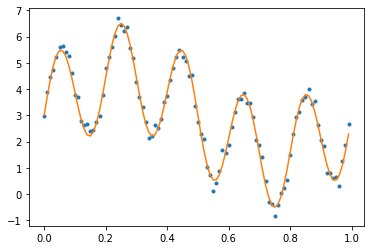

In [3]:
n=100
t=np.linspace(0,0.99,n)
f_true =3+ 1.5*np.sin(2*np.pi*t)+2*np.sin(10*np.pi*t)
ϵ=np.random.normal(scale=0.2,size=n)
f = f_true + ϵ
plt.plot(t,f,'.')
plt.plot(t,f_true)

목표: 파란점을관찰 $\to$ 주황점선을 추론

`-` 수식화하면 아래와 같다. 

$$f_i = 3+ 1.5\times \sin(2\pi t_i) + 2\times \sin(10 \pi t_i) +\epsilon_i,\quad t_i= \frac{i}{100}$$

회귀분석 느낌으로 표현하면 아래와 같이 표현가능하다. 

$$y_i= \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} +\epsilon_i$$

단, $x_{i1}=\sin(2\pi t_i)$ 이고 $x_{i2}=\sin(10\pi t_i)$. 

우리의 목표는 이제 아래와 같이 정리할 수 있다. 

- 주어진것: $(y_i, x_{i1}, x_{i2})$ 
- 목표: $\beta_0,\beta_1,\beta_2$를 추론 

### 방법1: 회귀분석 

`-` x1,x2,y를 아래와 같이 col-vector로 선언 

In [4]:
x1=np.sin(2*np.pi*t)
x2=np.sin(10*np.pi*t)

${\bf X}=[1,x1,x2]$ 라고 생각하고 회귀분석을 수행한다. 

---

- I의 역할은?

역행렬~

---

In [8]:
X=np.ones((n,3))
X[:,1]=x1
X[:,2]=x2
X=np.matrix(X)
y=np.matrix(f).T # y는 col-vec으로 선언 
βhat= (X.T*X).I*X.T*y
βhat

matrix([[3.0222137 ],
        [1.52753973],
        [1.9821308 ]])

`-` R을 이용해서 구해볼수도있음 

In [9]:
%R -i f,x1,x2

In [10]:
%%R 
lm(f~x1+x2)


Call:
lm(formula = f ~ x1 + x2)

Coefficients:
(Intercept)           x1           x2  
      3.022        1.528        1.982  



### 방법2: 

x1,x2을 모른다면? 우리가 $f=y$ 만 알고있다면? 

그러니까 $x_{i1}=\sin(2\pi t_i)$ 이고 $x_{i2}=\sin(10\pi t_i)$ 인지 모른다면? (구체적으로 2와 10과 같은 숫자를 모른다면? = 주파수를 모른다면?) 

잘은 모르겠지만 아래의 베이시스중에 하나는 걸릴것 같다

In [11]:
x1=np.sin(2*np.pi*t)
x2=np.sin(4*np.pi*t)
x3=np.sin(6*np.pi*t)
x4=np.sin(8*np.pi*t)
x5=np.sin(10*np.pi*t)

In [12]:
X=np.ones((n,6))
X[:,1]=x1
X[:,2]=x2
X[:,3]=x3
X[:,4]=x4
X[:,5]=x5
X=np.matrix(X)
βhat= (X.T*X).I*X.T*y
βhat

matrix([[ 3.02221370e+00],
        [ 1.52753973e+00],
        [ 4.83979815e-02],
        [-6.82103518e-04],
        [ 1.45162476e-04],
        [ 1.98213080e+00]])

그럴듯함 

적합해보자... 

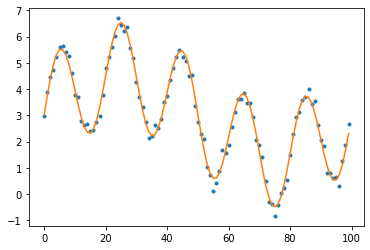

In [13]:
plt.plot(f,'.')
plt.plot(X*βhat)

비판1: 베이시스를 막 추가했는데 (=$p$가 늘어났는데) 오버피팅이 생기는것이 아닌가? $\to$ 절대안생김 

비판2: 저 베이시스중에서 안걸리면 어떻게 할것임? $\to$ 무한대의 베이시스를 쓰겠음 $\Longrightarrow$ 이게 퓨리에변환 

```python
x1=np.sin(2*np.pi*t)
x2=np.cos(2*np.pi*t)
x3=np.sin(4*np.pi*t)
x4=np.cos(4*np.pi*t)
x5=np.sin(6*np.pi*t)
x6=np.cos(6*np.pi*t)
x7=np.sin(8*np.pi*t)
x8=np.cos(8*np.pi*t)
... 
# 수틀리면 베이시스 더 쓸수도 있다 --> 무한대까지 쓸 수 있지만 무한대까지 쓸 필요는 없음.. (나이퀴스트 정리) 
```

---

나이퀴스트 정리 Nyquist theorem
- 모든 신호는 그 신호에 포함된 가장 높은 진동수의 2배에 해당하는 빈도로 일정한 간격으로 샘플링하면 원래의 신호를 완벽하게 기록할 수 있음.

---

### 방법3: 퓨리에변환 

`-` 퓨리에 변환 결과 

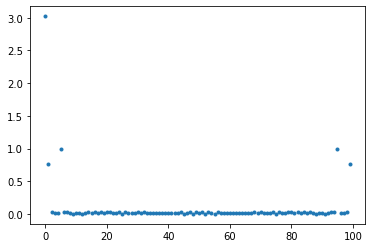

In [14]:
fbar = np.abs(np.fft.fft(f))/100
plt.plot(fbar,'.')

`-` 세부적인 이론이 있지만 실수인 경우는 fbar는 아래의 특징을 가짐 
- fbar[0]을 제외하고 나머지는 대칭임. 

----

- 이는 타임도메인이 실수인 경우에 한정된다.
    - 함수(시간영역, time domain)에 정현파sin가 곱해지면 스펙트럼이 두 개로 갈라져 좌우대칭을 이루기 때문
    - sin과 cos인 위상차이만 있을 뿐.
- 타임도메인에 복소수가 곱해질 경우 대칭되지 않음
    - 타임 도메인에 복소 신호가 더해지면 스펙트럼은 좌우대칭이 아니다
    - 오히려 축 위에서 이동shift 하는 현상이 일어난다.

---

`-` 따라서 그림을 아래와 같이 그려도 정보손실없음 

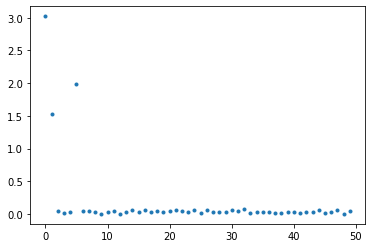

In [15]:
fbar2=np.zeros(50)
fbar2[0] = fbar[0] 
fbar2[1:50] = 2*fbar[1:50]
plt.plot(fbar2,'.')

대충보면 인덱스 10이전까지의 값만 살펴보면 될것 같고 나머지는 0근처임 

In [16]:
fbar2[:10]

array([3.0222137 , 1.52878178, 0.04930339, 0.02379494, 0.0351138 ,
       1.98223735, 0.05434901, 0.04658566, 0.0287547 , 0.00433721])

In [17]:
fbar2[[0,1,5]]

array([3.0222137 , 1.52878178, 1.98223735])

이것은 각각 1,x1,x2에 대한 베이시스값임을 알 수 있다. 

`-` 퓨리에 변환요약: 아무생각없이 무한대의 베이시스를 넣고 계수값을 구하면 잘 적합된다. 

`-` 퓨리에의 통찰: 어지간한 함수는 저주파부터 고주파의 cos함수(혹은 sin함수)에 적당한 계수를 곱한뒤 합치면 표현가능하다. 

### PCA

`-` 생각해보니까 베이시스를 무한대로 넣는것이 매우 통쾌해보임 

`-` 종종 $p$가 너무 커서 곤란한 상황이 많음. $\to$  공부해야할 것도 많음. 
- 다중공선성 
- 오버피팅 
- 변수선택 
- ... 

`-` 베이시스가 직교였더라면.. $\to$ 기존 베이시스를 변환하여 직교 베이시스로 만들자! 

`-` 기존베이시스를 변환하여 직교베이시스로 만드는 방법: Eigen-value decomposition, SVD 

(1) 디자인 매트릭스 ${\bf X}=[1,X_1,\dots,X_p]$ 를 만든다. 

(2) ${\bf X}^\top {\bf X}$ 를 계산한다. 

(3) ${\bf X}^\top{\bf X}$ 의 고유값분해를 계산한다. (고유값분해는 항상가능하다, 왜?) 
- ${\bf X}^\top {\bf X} = {\boldsymbol \Psi}{\boldsymbol \Lambda} {\boldsymbol \Psi}^\top$ 

---

${\bf X}^\top{\bf X}$ 가 positive 여서

---

(4) 아래의 수식을 관찰하여 새로운 매트릭스 ${\bf Z}$를 만든다. ${\bf Z}$는 ${\bf X}$가 가진 모든 정보량을 가지고 있으며 (정말?) 직교기저를 가진다. 
- ${\bf X}^\top {\bf X} = {\boldsymbol \Psi}{\boldsymbol \Lambda} {\boldsymbol \Psi}^\top = {\boldsymbol \Psi}{\boldsymbol \Lambda}^{\frac{1}{2}} {\boldsymbol \Lambda}^{\frac{1}{2}}{\boldsymbol \Psi}^\top = {\bf Z}^\top {\bf Z}$
- 여기에서 ${\boldsymbol \Lambda}^{1/2}$는 ${\boldsymbol \Lambda}$의 모든 고유값에 루트를 취한것. 이것이 가능하려면 ${\boldsymbol \Lambda}^{1/2}$의 모든 고유값이 양수라는 조건이 필요할텐데, 사실 ${\boldsymbol \Lambda}^{1/2}$의 모든 고유값은 양수임 (왜?)

`-` 비판: 진짜 ${\bf Z}$가 ${\bf X}$의 모든 정보량을 가지고 있을까? 이 말은 ${\bf X}^\top {\bf X}$가 ${\bf X}$의 모든 정보량을 가지고 있다는 말과 같은데 진짜 그럴까? $\to$ **정규분포 한정으로 맞는말**

`-` 아이디어: 앞으로 ${\bf X}$가 오면 다중공선성이니 오버피팅이니 변수선택이니 생각하지 말고 무조건 ${\bf Z}$로 바꿔서 분석하자. 그러면 최소한 적합은 잘된다. 

`-` 잠깐생각
- 그런데 일반적으로 ${\bf X}$로 ${\bf y}$를 맞출때, ${\bf X}$의 모든 변수가 유의미하진 않을것. 예를들어 2개만 유의미하다고 해보자. 
- 그렇다면 ${\bf Z}$의 모든 변수역시 유의미하지 않을것. 그리고 이러한 변수에 붙는 계수값은 2개를 제외하고 0에 가까울것으로 생각됨. $\to$ 그 2개 빼고 다 버리자 = 차원축소 

`-` 장점만 있는건 아님. 단점도 존재함. (계수의 의미를 해석하는게 조금 힘들다) 

---

${\boldsymbol \Lambda}^{1/2}$는 ${\boldsymbol \Lambda}$를 ${\boldsymbol \Lambda}^{1/2}$ X ${\boldsymbol \Lambda}^{1/2}$ 로 나타낸 것이기 때문에?

---

### Graph Laplacian  

`-` 주어진자료를 시계열로 해석 

In [18]:
_W =[[np.abs(i-j)==1 for i in range(n)] for j in range(n)]
W=np.array(_W,dtype='float')
W

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

`-` 대응하는 ${\bf D}$는 아래와 같음 

In [19]:
D=np.diag(W.sum(axis=1))
D

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

`-` 그렇다면 ${\bf L}$은 아래와 같이 정의할 수 있음 

In [20]:
L=D-W
L

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

`-` 고유값분해 

${\bf L}$은 모든 원소가 실수이며 대칭행렬이므로 Eigenvalue decomposition이 가능함

In [21]:
λ, Ψ = np.linalg.eig(L) # 람다는 고유값, 프사이는 고유벡터행렬 

- `\lambda + tab `, `\Psi + tab`

In [22]:
Λ = np.diag(λ) 

Note that ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [23]:
L

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

- `L = Ψ @ Λ @ Ψ.transpose()` 

그런데 

${\boldsymbol \Psi} {\boldsymbol \Lambda} {\boldsymbol \Psi}^\top = \sum_{j=1}^{100} \psi_j \lambda_j \psi_j^\top$ where ${\boldsymbol \Psi} = [\psi_1,\dots,\psi_{100}]$ 

---

In [24]:
Ψ@Λ@Ψ.T

array([[ 1.00000000e+00, -1.00000000e+00, -1.77388390e-15, ...,
        -1.29097491e-15,  9.74047232e-16, -1.70002901e-16],
       [-1.00000000e+00,  2.00000000e+00, -1.00000000e+00, ...,
         2.27039250e-15, -1.30581310e-15,  8.49147141e-16],
       [-1.70471180e-15, -1.00000000e+00,  2.00000000e+00, ...,
        -2.99733112e-15,  1.22474800e-15, -6.85887016e-16],
       ...,
       [-1.30604532e-15,  2.27884927e-15, -3.05349279e-15, ...,
         2.00000000e+00, -1.00000000e+00, -9.05895822e-15],
       [ 9.68843061e-16, -1.32446137e-15,  1.24372153e-15, ...,
        -1.00000000e+00,  2.00000000e+00, -1.00000000e+00],
       [-1.70002901e-16,  8.43942971e-16, -6.87947000e-16, ...,
        -9.04030994e-15, -1.00000000e+00,  1.00000000e+00]])

---

`-` 그려보자. 

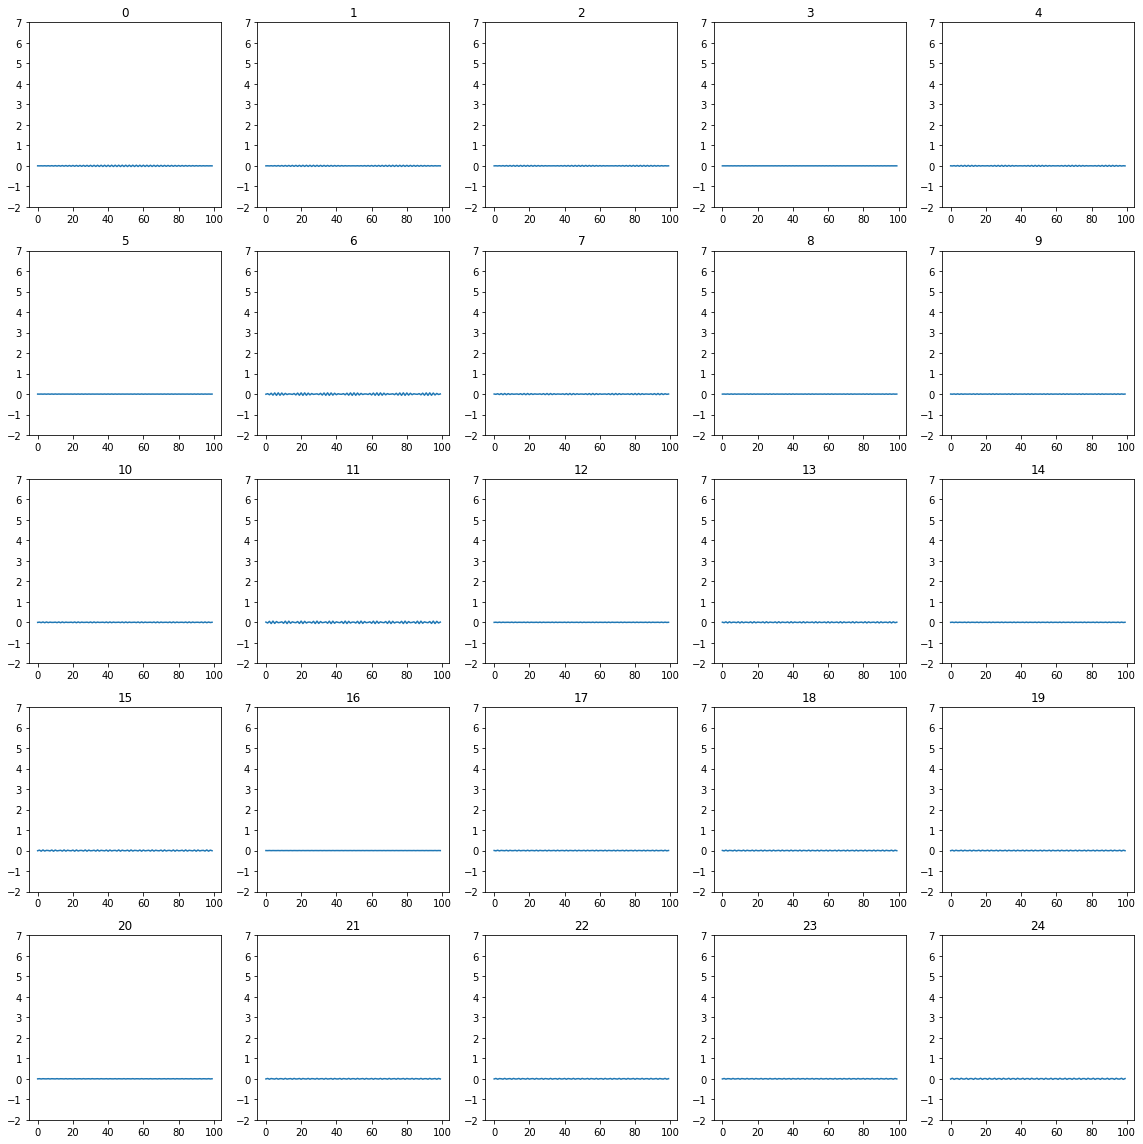

In [25]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

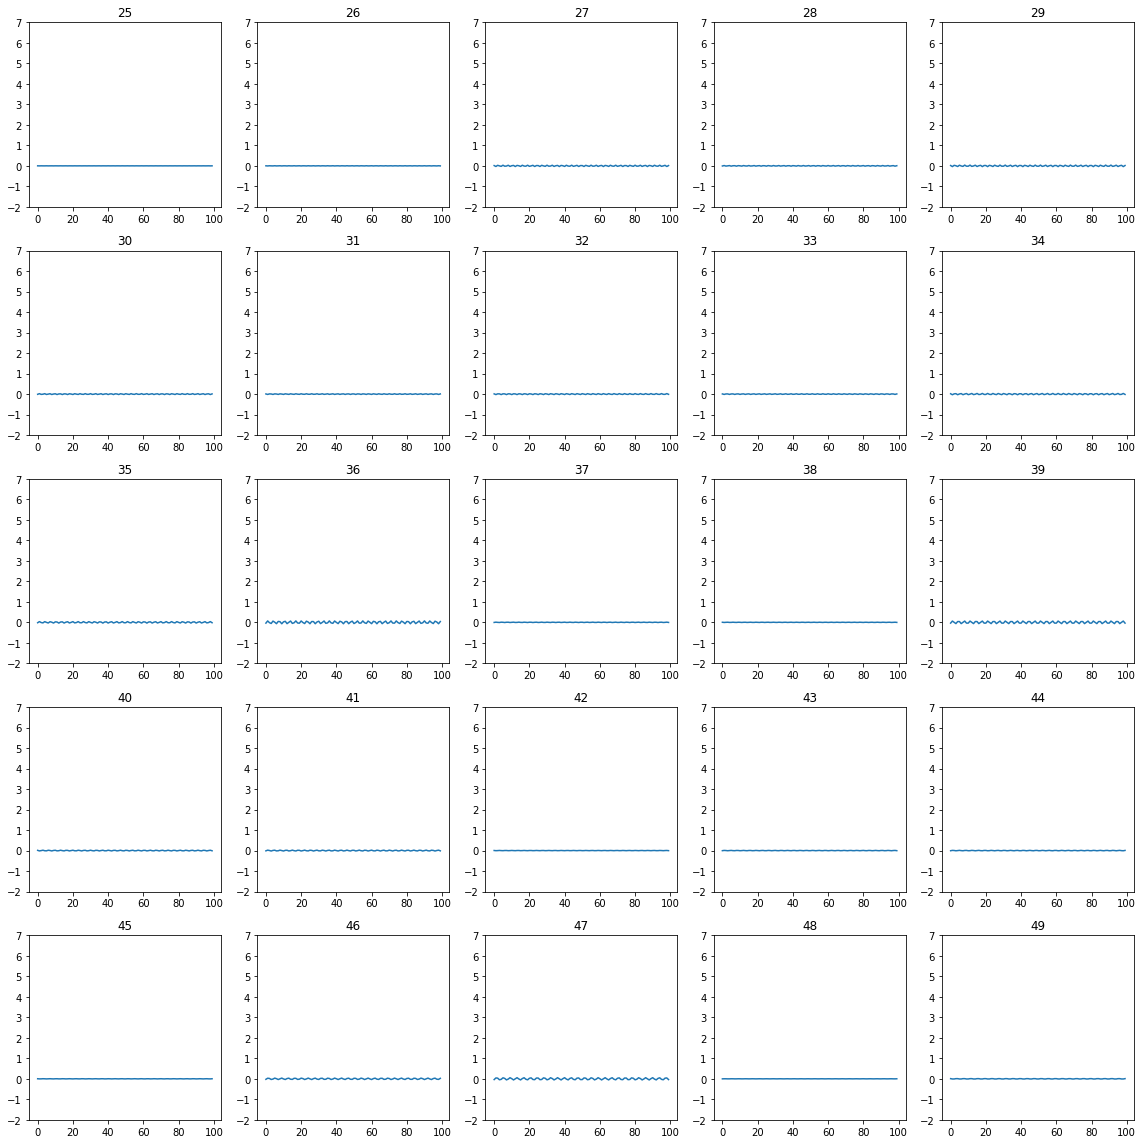

In [26]:
fig,ax =plt.subplots(5,5)
k=25
for i in range(5):
    for j in range(5):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

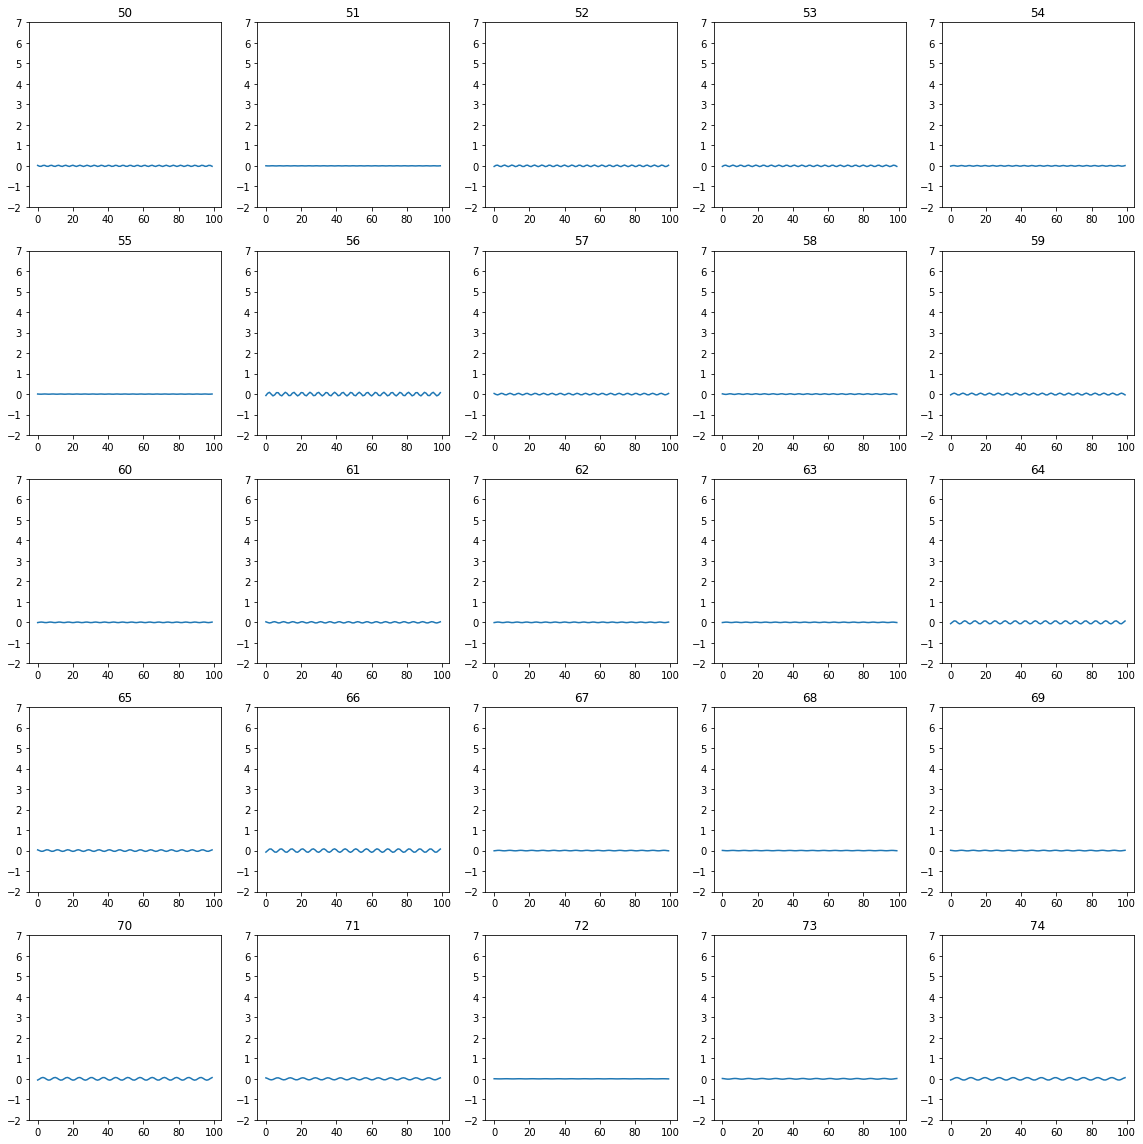

In [27]:
fig,ax =plt.subplots(5,5)
k=50
for i in range(5):
    for j in range(5):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

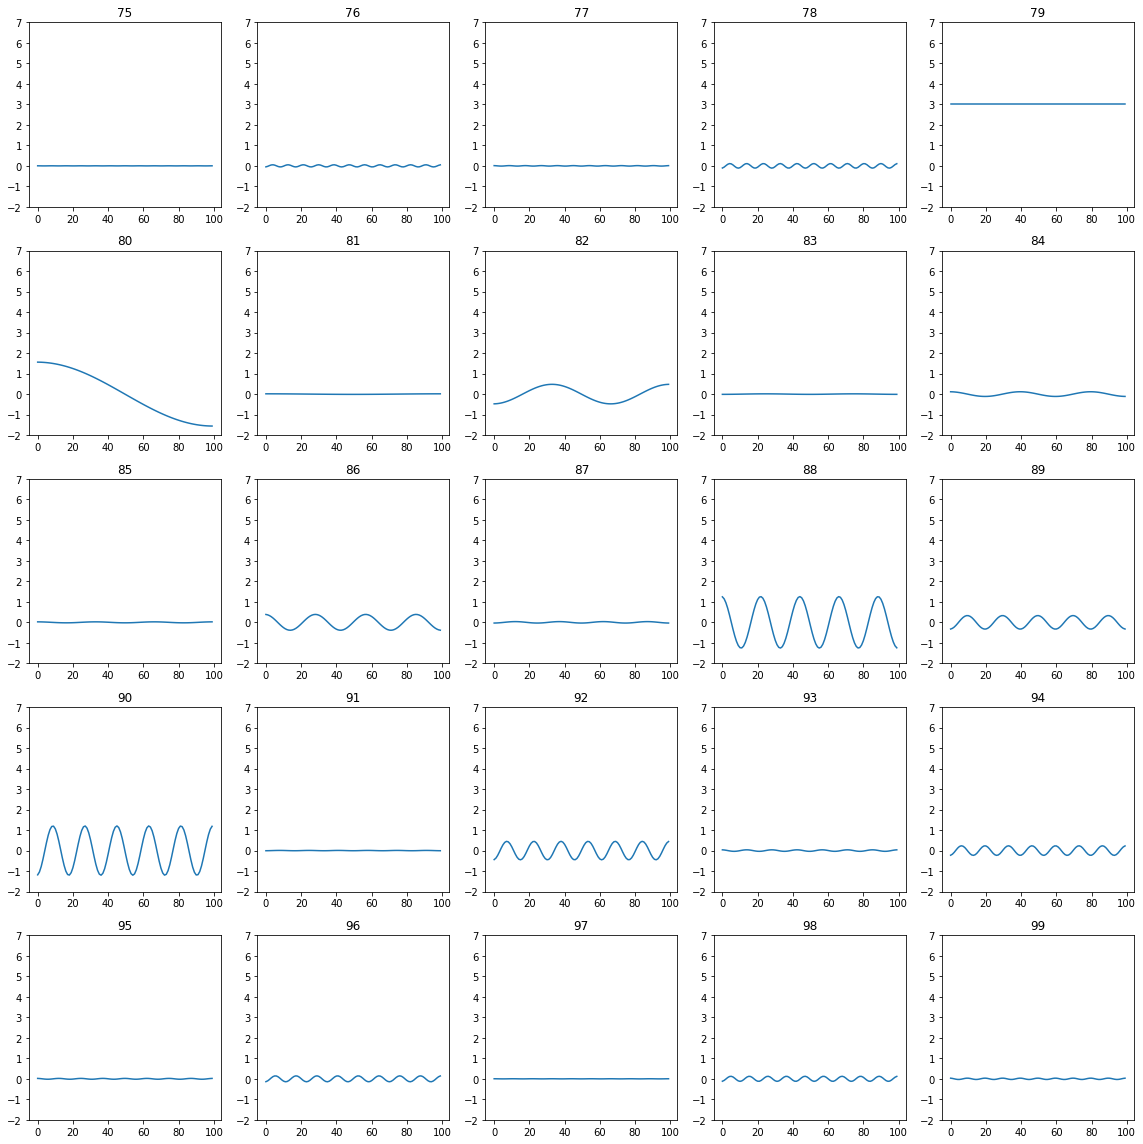

In [28]:
fig,ax =plt.subplots(5,5)
k=75
for i in range(5):
    for j in range(5):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout() 

`-` 마지막 25개 정도가 크리티컬해보인다.

- 79,80,82,84,86,88,89,90,92,94,96,98 정도를 실제 베이시스와 겹쳐서 다시그려보자. 

In [29]:
comp1= [3]*n
comp2= 1.5*np.sin(2*np.pi*t)
comp3= 2*np.sin(10*np.pi*t)

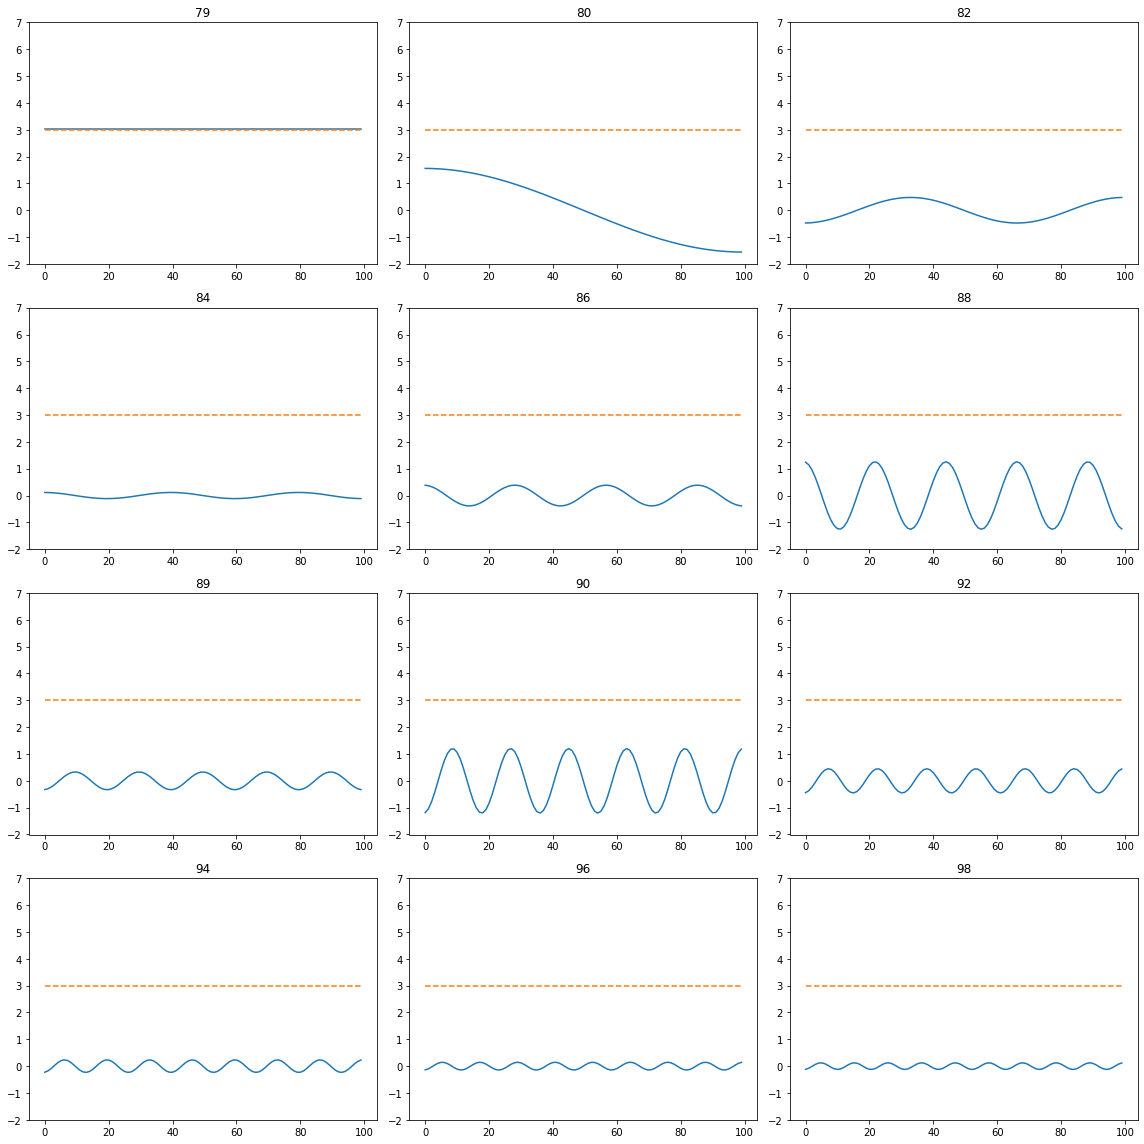

In [30]:
fig,ax =plt.subplots(4,3)
klist=[79,80,82,84,86,88,89,90,92,94,96,98]
k=0
for i in range(4):
    for j in range(3):
        ax[i][j].plot(f @ np.outer(Ψ[:,klist[k]], Ψ[:,klist[k]]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(klist[k])
        ax[i][j].plot(comp1,'--')
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout() 

- 대충 79번아이겐벡터에 해당하는것이 comp1의 추정치로 적당한듯 

In [31]:
comp1hat= f @ np.outer(Ψ[:,79], Ψ[:,79])

(-2.0, 7.0)

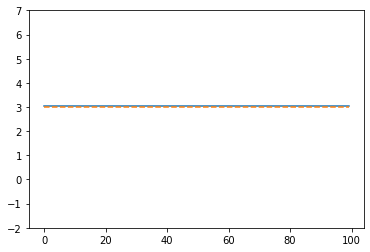

In [32]:
plt.plot(comp1hat)
plt.plot(comp1,'--')
plt.ylim([-2,7])

`-` 두번째 comp를 추정해보자. 

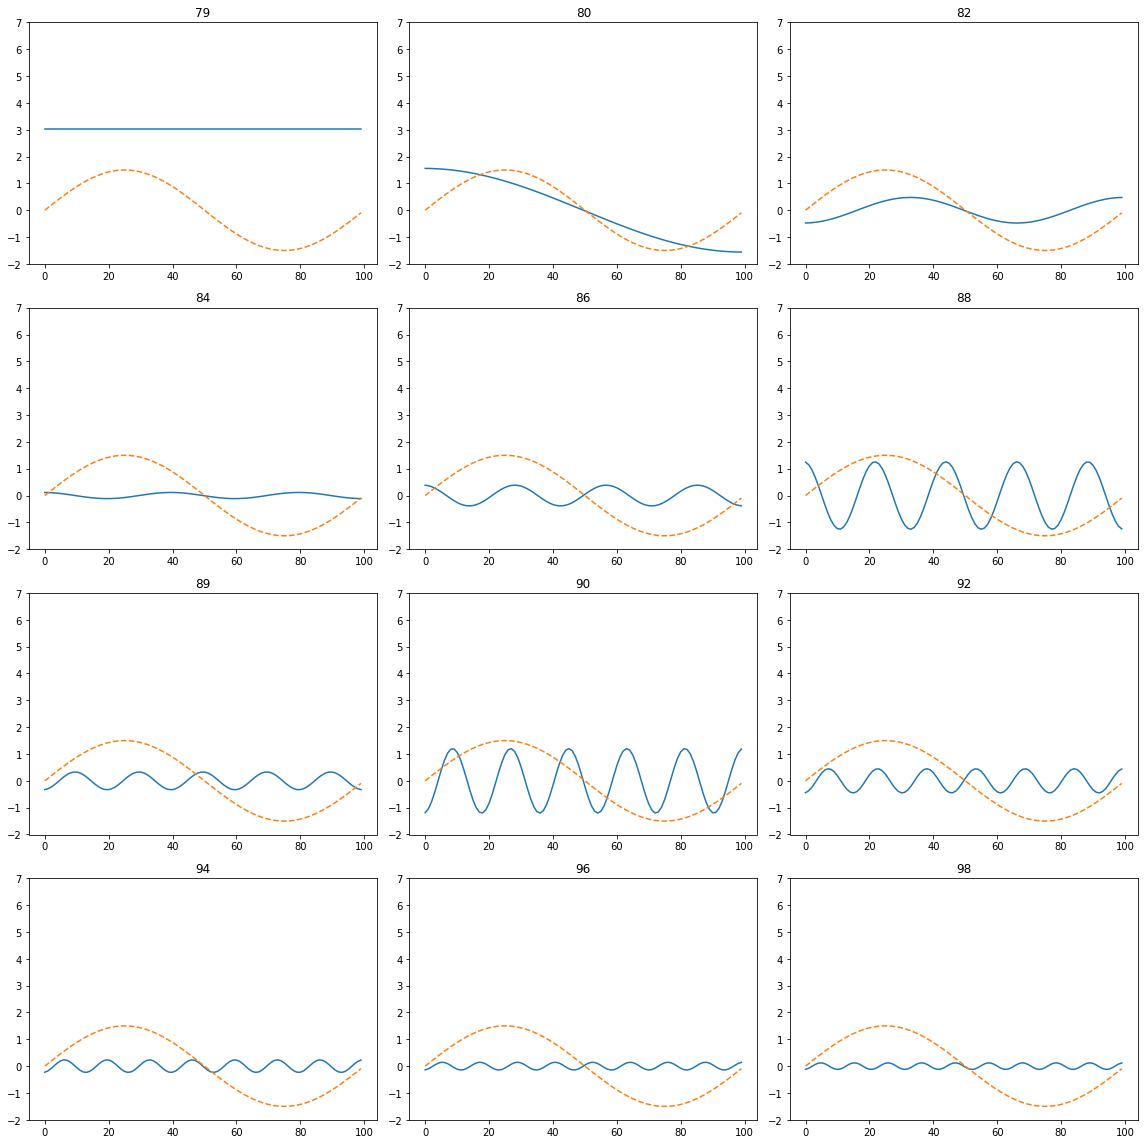

In [33]:
fig,ax =plt.subplots(4,3)
klist=[79,80,82,84,86,88,89,90,92,94,96,98]
k=0
for i in range(4):
    for j in range(3):
        ax[i][j].plot(f @ np.outer(Ψ[:,klist[k]], Ψ[:,klist[k]]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(klist[k])
        ax[i][j].plot(comp2,'--')
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout() 

- 80+82 정도면 될거같다. 

In [34]:
comp2hat= f @ np.outer(Ψ[:,80], Ψ[:,80]) +f @ np.outer(Ψ[:,82], Ψ[:,82])

(-2.0, 7.0)

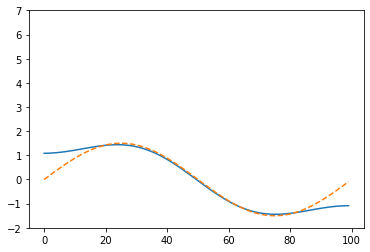

In [35]:
plt.plot(comp2hat)
plt.plot(comp2,'--')
plt.ylim([-2,7])

`-` 세번쨰 콤포넌트 

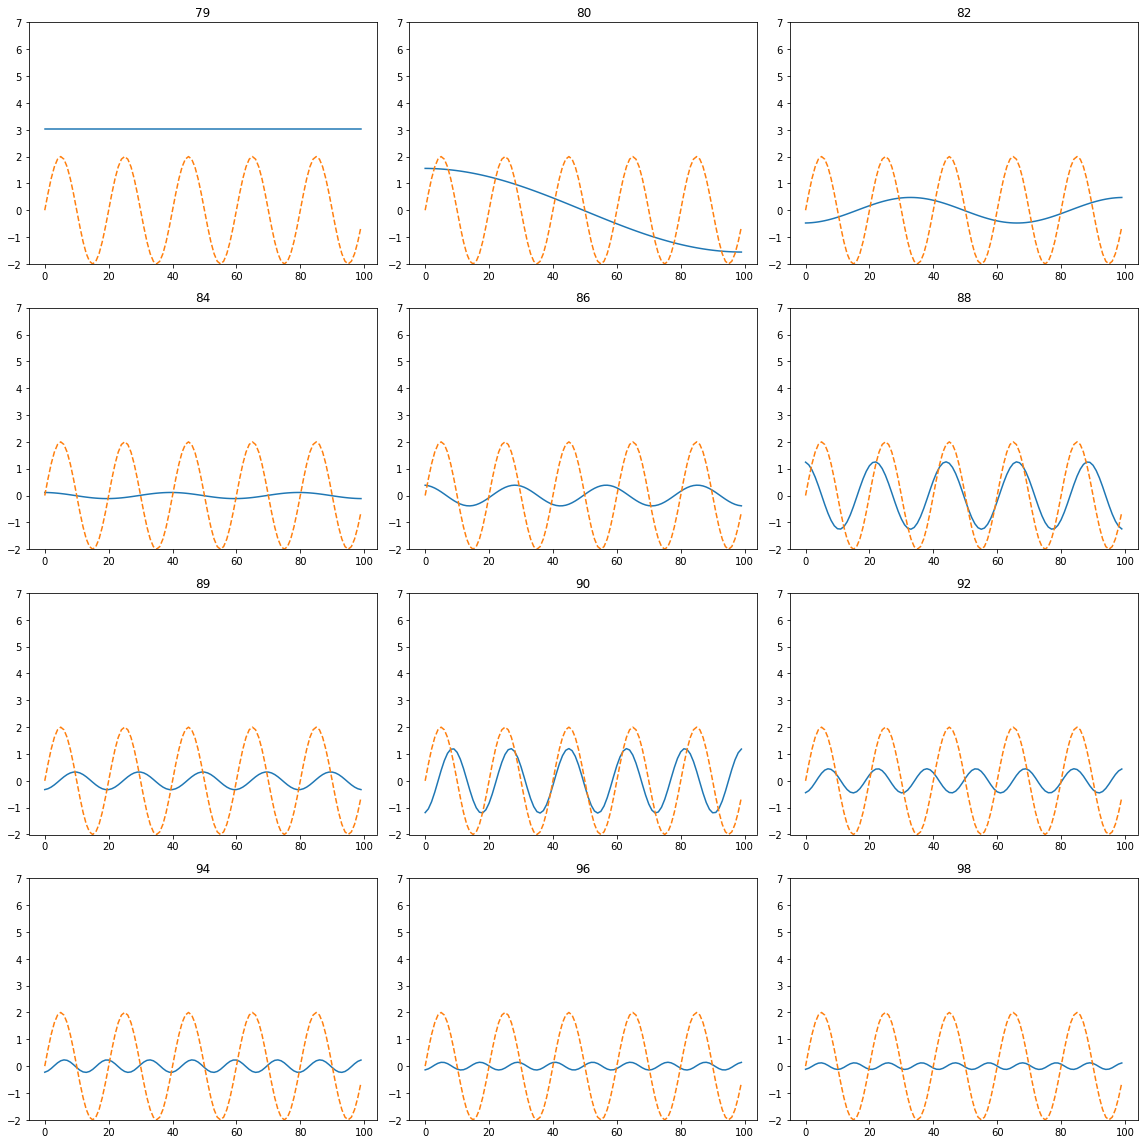

In [36]:
fig,ax =plt.subplots(4,3)
klist=[79,80,82,84,86,88,89,90,92,94,96,98]
k=0
for i in range(4):
    for j in range(3):
        ax[i][j].plot(f @ np.outer(Ψ[:,klist[k]], Ψ[:,klist[k]]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(klist[k])
        ax[i][j].plot(comp3,'--')
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout() 

- 88+90 정도면 적당하지 않을까? 

(-3.0, 7.0)

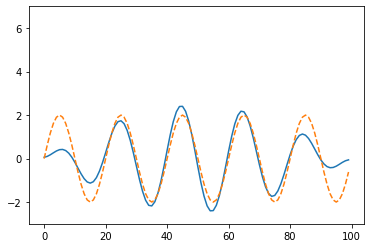

In [37]:
comp3hat= f @ np.outer(Ψ[:,88], Ψ[:,88]) +f @ np.outer(Ψ[:,90], Ψ[:,90])
plt.plot(comp3hat)
plt.plot(comp3,'--')
plt.ylim([-3,7])

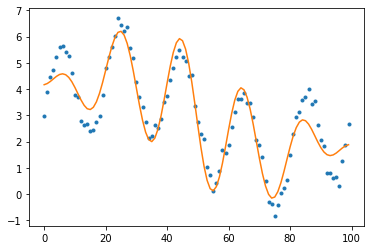

In [57]:
plt.plot(f,'.')
plt.plot(comp1hat + comp2hat + comp3hat)

### 그래프 라플라시안의 의미 

#### 예제1: 노드간의 모든연결을 가정하는 자료 

`-` 예제

In [38]:
n=100
y=np.random.randn(n)+2 

`-` 이런 모델로 생각해보자. 

$$y_i= \beta_0 + \epsilon_i$$

여기에서 $\beta_0=2$

`-` 분산비슷한거

In [39]:
np.std(y)**2*n ## SSE

69.87760050954996

`-` 제곱합분해의 관점 

In [40]:
y@y ## SST 

493.74596805115874

In [41]:
(y-np.mean(y))@(y-np.mean(y)) ## SSE

69.87760050954995

In [42]:
(y*0-np.mean(y))@(y*0-np.mean(y)) ## SSH

423.8683675416089

In [43]:
(y-np.mean(y))@(y-np.mean(y))+ (y*0-np.mean(y))@(y*0-np.mean(y)) ## SSE + SSH = SST 

493.74596805115885

`-` 그래프라플라시안 

In [44]:
W=np.ones((n,n)) # 노드가 다 연결되었다고 생각하자
D=np.diag(W.sum(axis=1))
L=D-W

In [45]:
y@L@y/n ## SSE네?

69.87760050955004

In [46]:
y@W@y/n ## SSH네

423.8683675416086

In [47]:
y@D@y/n ## SST

493.74596805115885

#### 예제2: 일부연결만 가정하는자료 

`-` 시계열일경우 (노드를 다 연결할 필요는 없음)

In [48]:
_=[(f[i]-f[i-1])**2 for i in range(1,100)]
np.array(_).sum()

27.651968559196874